# Hydrological Signatures

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import hydrosignatures as hs
import pydaymet as daymet
import pygeohydro as gh
from hydrosignatures import HydroSignatures
from pygeohydro import NWIS
from pynhd import WaterData

Let's explore the capabilities of ``HydroSignatures`` by getting streamflow using PyGeoHydro, basin geometry using PyNHD and precipitation using PyDaymet. In this example, we select West Branch Herring Run At Idlewylde, MD, as the watershed of interest and compute the hydrological signatures for the period from 2010 to 2020.

In [2]:
site = "01585200"
start = "2010-01-01"
end = "2020-12-31"

First, we get the basin geometry of the watershed using ``gagesii_basins`` layer of the USGS's WaterData web service.

In [3]:
wd = WaterData("gagesii_basins")
geometry = wd.byid("gage_id", site).geometry[0]

Then, we obtain the station's info and streamflow data using NWIS. Note that we should convert the streamflow from cms to mm/day.

In [4]:
nwis = NWIS()
info = nwis.get_info({"site": site})
area_sqm = info.nhd_areasqkm.values[0] * 1e6
q_cms = nwis.get_streamflow(site, (start, end))
q_mmpd = q_cms.squeeze() * (24.0 * 60.0 * 60.0) / area_sqm * 1e3
q_mmpd.index = pd.to_datetime(q_mmpd.index.date)

Next, we retrieve the precipitation data using PyDaymet over the whole basin using the basin geometry and take its mean as the basin's precipitation.

In [5]:
prcp = daymet.get_bygeom(geometry, (start, end), variables="prcp")
p_mmpd = prcp.prcp.mean(dim=["x", "y"]).to_pandas()
p_mmpd.index = pd.to_datetime(p_mmpd.index.date)
q_mmpd = q_mmpd.loc[p_mmpd.index]

Now, we can pass these two to the ``HydroSignatures`` class:

In [6]:
sig = HydroSignatures(q_mmpd, p_mmpd)

The ``values`` property of this class contains the computed signatures. For example, let's plot the regime curves:

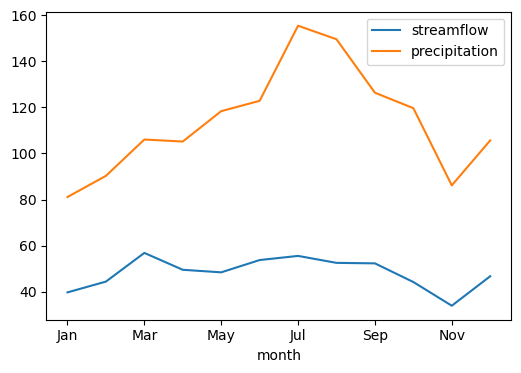

In [7]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.set_xlabel("")
ax.set_ylabel("")
sig.values.mean_monthly.plot(ax=ax)
fig.savefig(Path("_static", "signatures_rc.png"))

Note that, you can also use the functions directly. For example, let's get streamflow observations for another station and separate the baseflow using various filter parameters and compare them:

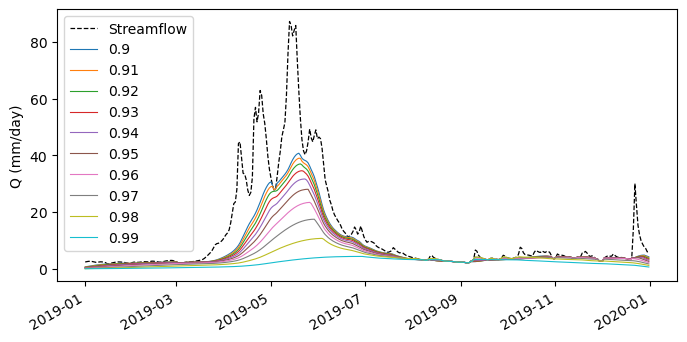

In [8]:
q = nwis.get_streamflow("12304500", ("2019-01-01", "2019-12-31"))
q = q.rename(columns={"USGS-12304500": "Streamflow"})
alpha = np.arange(0.9, 1, 0.01)
qb = pd.DataFrame({round(a, 2): hs.compute_baseflow(q.squeeze(), alpha=a) for a in alpha})

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
ax.set_xlabel("")
ax.set_ylabel("Q (mm/day)")
q.plot(ax=ax, c="k", ls="--", lw=0.9)
qb.plot(ax=ax, lw=0.8)
fig.savefig(Path("_static", "signatures_bf.png"))

Lastly, let's compute Markham's seasonality index for all streamflow time series of the stations in the CAMELS dataset. We retrieve the CAMELS dataset using PyGeoHydro:

In [9]:
camels_basin, camels_qobs = gh.get_camels()

Since `compute_si_markham` function accepts `pandas.DataFrame` or `pandas.Series`, we need to convert the streamflows from `xarray.Dataset` to `pandas.DataFrame`. Some stations have negative discharge values that we need to replace with zero.

In [10]:
discharge = camels_qobs.discharge.dropna("station_id")
discharge = xr.where(discharge < 0, 0, discharge)
camels_basin = camels_basin.loc[discharge.station_id]

Finally, we compute the seasonality index and merge it with the `camels_basin` dataframe for visualization. We can also use `get_us_states` from PyGeoHydro to add CONUS to the plot.

In [11]:
camels_basin = camels_basin.merge(
    hs.compute_si_markham(discharge.to_pandas()), left_index=True, right_index=True
)

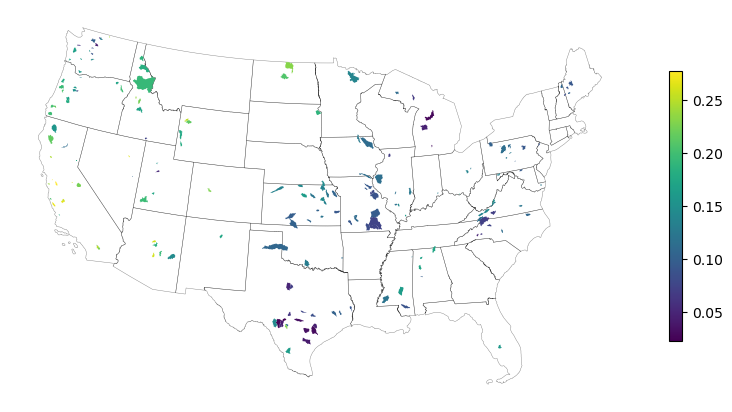

In [12]:
conus = gh.helpers.get_us_states("contiguous")

fig, ax = plt.subplots(figsize=(10, 7), dpi=100)
conus.to_crs(5070).plot(ax=ax, facecolor="none", edgecolor="k", lw=0.3, alpha=0.5)
camels_basin.to_crs(5070).plot(
    column="seasonality_index", cmap="viridis", ax=ax, legend=True, legend_kwds={"shrink": 0.5}
)
ax.set_axis_off()